<a href="https://colab.research.google.com/github/joannamwalsh/GLMFinalProject/blob/main/FinalProjectGLMCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages(c("tensorflow","keras"))
install.packages("caret")
install.packages("varhandle")

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(keras)
library(tidyverse)
library(caret)
library(pROC)
library(varhandle)

In [ ]:
imagedata <- read.csv("/content/imagedata.csv")
names(imagedata) <- c(paste("pixel.", seq(1, (ncol(imagedata) - 1), 1)), "DX")
imagedata <- imagedata %>% mutate(DX = case_when(DX == "Non Demented" ~ 1, 
                                            DX == "Very Mild Demented" ~ 2, 
                                            DX == "Mild Demented" ~ 3, 
                                            DX == "Moderate Demented" ~ 4))
imagedata$DX <- factor(imagedata$DX)
levels(imagedata$DX)

[1] "1" "2" "3" "4"

In [ ]:
set.seed(1)
folds <- createFolds(imagedata, k = 10, list = TRUE, returnTrain = FALSE)

In [ ]:
i <- 1
train <- imagedata[-folds[[i]], ]
test <- imagedata[folds[[i]], ]
y <- train$DX
y_mat <- to_categorical(y)[, 2:5]
X <- as.matrix(train[, -ncol(train)])
train_means <- apply(X, 2, mean)
train_sd <- sd(as.vector(X))
X <- sweep(X, 2L, train_means)/train_sd

y_test <- test$DX
y_mat_test <- to_categorical(y_test)[, 2:5]
X_test <- as.matrix(test[, -ncol(test)])
X_test <- sweep(X_test, 2L, train_means)/train_sd

ERROR: ignored

In [ ]:
set.seed(1)
sequence = seq(1, 6400, 1)
for (i in 1:10) {
folds[[i]] <- sample(size = 640, x = sequence, replace = FALSE)
sequence = sequence[!(sequence %in% folds[[i]])]
}



In [ ]:
loss <- c()
accuracy <- c()
mcroc <- c()
actltpred <- c()
actgtpred <- c()
for (i in 1:10) {
  train <- imagedata[-folds[[i]], ]
  test <- imagedata[folds[[i]], ]
  y <- train$DX
  y_mat <- to_categorical(y)[, 2:5]
  X <- as.matrix(train[, -ncol(train)])
  train_means <- apply(X, 2, mean)
  train_sd <- sd(as.vector(X))
  X <- sweep(X, 2L, train_means)/train_sd

  y_test <- test$DX
  y_mat_test <- to_categorical(y_test)[, 2:5]
  X_test <- as.matrix(test[, -ncol(test)])
  X_test <- sweep(X_test, 2L, train_means)/train_sd

  X <- array_reshape(X,c(nrow(X),43,43, 1))
  X_test <- array_reshape(X_test,c(nrow(X_test),43,43, 1))
  model <- keras_model_sequential()  %>% # Start with hidden 2D convolutional layer being fed 43x43 pixel images
  layer_conv_2d(filters = 43, kernel_size = c(3,3), input_shape = c(43, 43, 1), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>% 
  layer_conv_2d(filters = 86, kernel_size = c(3,3),activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>%
  layer_conv_2d(filters = 172, kernel_size = c(3,3),activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>%
  layer_flatten() %>%
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 344, activation = "relu") %>%
  layer_dense(units = 4, activation = "softmax")

  model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = "adam",
  metrics= "accuracy")
  
  history <- model %>% fit(x = X, y = y_mat, epochs = 20, validation_data = list(X_test, y_mat_test))
  loss <- c(loss, evaluate(model, X_test, y_mat_test)[1])
  accuracy <- c(accuracy, evaluate(model, X_test, y_mat_test)[2])

  predictions <- predict(model, X_test)
  colnames(predictions) <- c("1", "2", "3", "4")
  mcroc <- c(mcroc, multiclass.roc(test$DX, predictions)$auc)
  predclasses <- as.vector(predict(model, X_test) %>% k_argmax()) + 1

  test$DXunf <- unfactor(test$DX)
  actltpred <- c(actltpred, sum(test$DXunf < predclasses)/length(predclasses))
  actgtpred <- c(actgtpred, sum(test$DXunf > predclasses)/length(predclasses))
}

In [ ]:
results <- as.data.frame(cbind(unname(loss), unname(accuracy), mcroc, actltpred, actgtpred))
names(results) <- c("loss", "accuracy", "mcroc", "actltpred", "actgtpred")
write.csv(results, file = "results.csv")

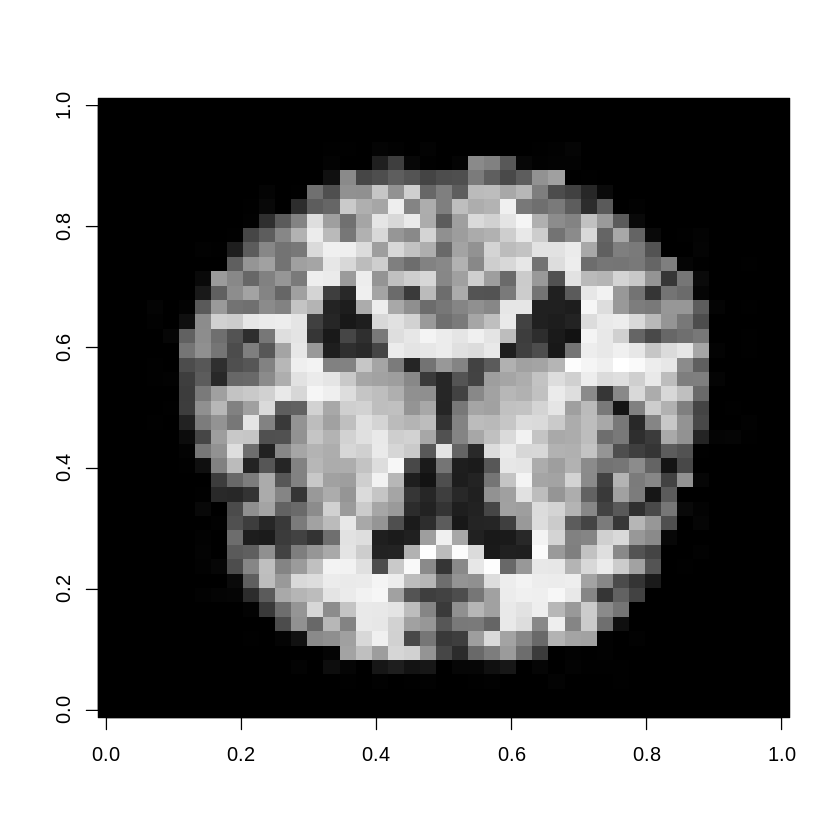

In [ ]:
i <- 7
single_brain <- matrix(as.numeric(imagedata[i, -ncol(imagedata)]), nrow=43, ncol=43)
single_brain <- single_brain[,ncol(single_brain):1]
image(single_brain,col=grey(seq(0, 1, length=256)))

i <- 7
single_brain <- matrix(as.numeric(X[i,]), nrow=43, ncol=43)
single_brain <- single_brain[,ncol(single_brain):1]
image(single_brain,col=grey(seq(0, 1, length=256)))

In [ ]:
summary(model)

Model: "sequential_7"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_26 (Conv2D)                 (None, 41, 41, 43)              430         
 max_pooling2d_26 (MaxPooling2D)    (None, 20, 20, 43)              0           
 conv2d_25 (Conv2D)                 (None, 18, 18, 86)              33368       
 max_pooling2d_25 (MaxPooling2D)    (None, 9, 9, 86)                0           
 conv2d_24 (Conv2D)                 (None, 7, 7, 172)               133300      
 max_pooling2d_24 (MaxPooling2D)    (None, 3, 3, 172)               0           
 flatten_7 (Flatten)                (None, 1548)                    0           
 dropout_7 (Dropout)                (None, 1548)                    0           
 dense_15 (Dense)                   (None, 344)                     532856      
 dense_14 (Dense)                   (None, 4)                       1380        
Total 

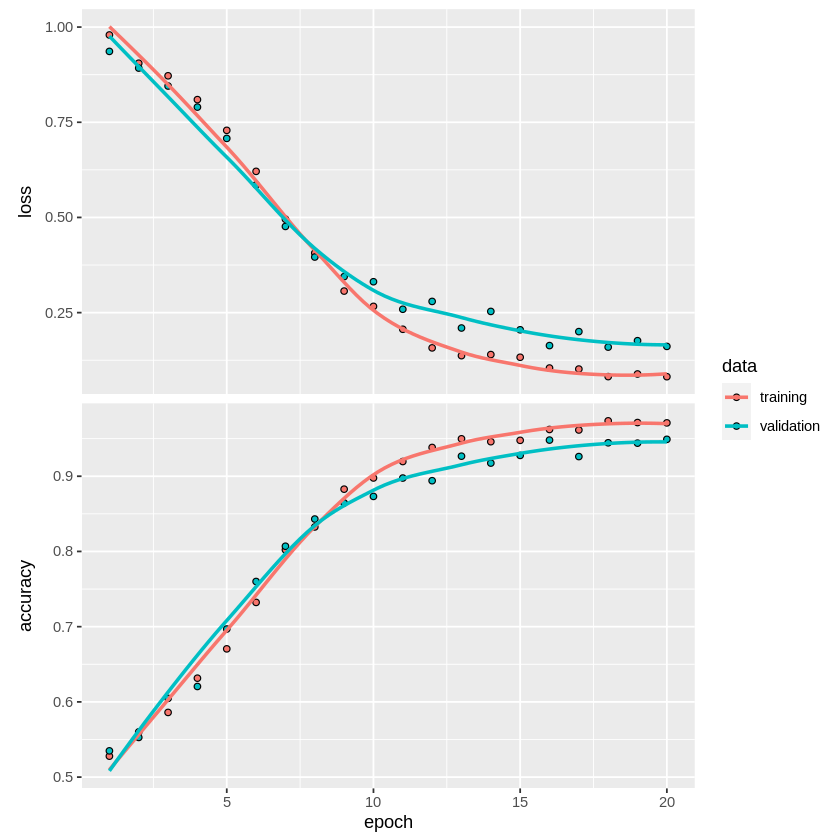

In [ ]:
plot(history)